In [1]:
import os
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler
os.chdir('..')

In [2]:
from src.experiment import CLIPGraphRun
from src.data import ImageDataset
from src.utils import load_ruamel
from src.data import DataDict

In [3]:
# taking 1_000 artworks, stratyfing on the style

In [4]:
num_sampled_artworks = 100

In [5]:
test_set = pd.read_csv('./data/processed/normal/artgraph_clip_genre/test.csv')
test_set

,artwork,genre
0,konstantin-korovin_morning-1914.jpg,landscape
1,jimmy-ernst_synapse-1950.jpg,abstract
2,nicholas-roerich_lahaul-himalayas-1932.jpg,landscape
3,vilho-lampi_self-portrait-1931.jpg,self-portrait
4,william-holman-hunt_may-morning-on-magdalen-co...,genre painting
...,...,...
11642,claude-monet_the-manneport.jpg,landscape
11643,george-romney_miss-martindale-1782.jpg,portrait
11644,jacques-louis-david_portrait-of-madame-charles...,portrait
11645,giovanni-bellini_pesaro-altarpiece-1474-2.jpg,religious painting


In [6]:
drop, sampled_test_set = train_test_split(test_set, test_size=num_sampled_artworks, stratify=test_set["genre"], random_state=42)
sampled_test_set

,artwork,genre
2677,esaias-van-de-velde_landscape-with-ruins-and-s...,landscape
4010,jean-honore-fragonard_the-adoration-of-the-she...,religious painting
6537,maurice-prendergast_central-park-1901.jpg,genre painting
270,francis-bacon_triptych-may-june-1973.jpg,figurative
3724,keith-haring_untitled-1987.jpg,abstract
...,...,...
11281,viktor-vasnetsov_brousov-calendar-1871.jpg,portrait
3773,peter-doig_music-of-the-future.jpg,landscape
7487,henri-martin_marine-breton.jpg,marina
9510,vasile-dobrian_the-waves-of-migrating-birds-ha...,abstract


In [7]:
parameters = load_ruamel('./configs_cineca/proposed_model/genre/normal_clip_graph_sage3.yaml')
parameters["clean_out_dir"] = False
parameters["model"]["gnn"]["params"]["dropout"] = 0.0
run = CLIPGraphRun(parameters=parameters)
run.load_state_dict()

Loading general parameters...
Done!
Loading dataloaders...
Done!
Loading model...
Done!
Loading metrics...
Done!
Loading tokenizer...
Done!
Loading criterion...
Done!
Loading optimizer...
Done!
Loading scheduler...
Done!
Loading early stop callback...
Done!
loading state dict


In [8]:
visual = run.model.visual
visual

VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (patch_dropout): Identity()
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ls_1): Identity()
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ls_2): Identity()
      )
    )
  )
  (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [9]:
sampled_image_test_dataset = ImageDataset(
    dataset=sampled_test_set,
    img_dir=run.test_loader.dataset.img_dir,
    preprocess=run.test_loader.dataset.preprocess,
)
batch_size=64
sampled_dataloader = DataLoader(
    dataset=sampled_image_test_dataset, batch_size=batch_size, shuffle=False, drop_last=False
)

In [10]:
out_features = torch.empty(size=(len(sampled_image_test_dataset), 512))
out_features.size()

torch.Size([100, 512])

In [11]:
with torch.no_grad():
    for ix, (data_dict) in tqdm(enumerate(sampled_dataloader), total=len(sampled_dataloader)):
        img_feats = visual(data_dict[DataDict.IMAGE].to("cuda"))
        start_idx = ix * batch_size
        end_idx = min((ix+1)*batch_size, out_features.size(0))
        out_features[start_idx: end_idx] = img_feats.cpu()

out_features = out_features.numpy()



  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.59it/s]


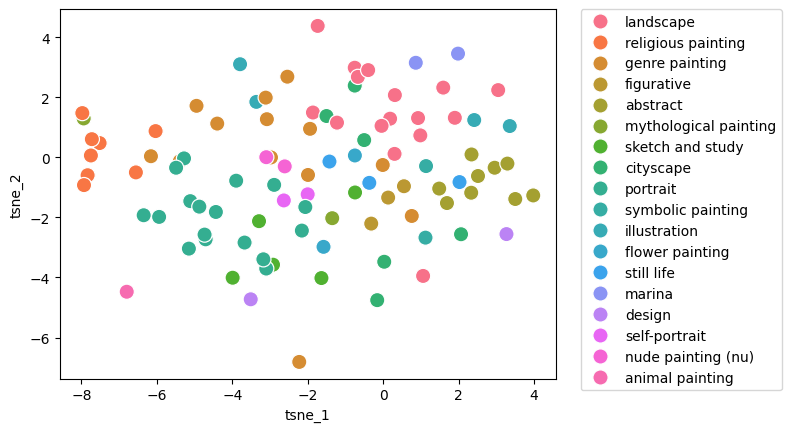

In [12]:
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(StandardScaler().fit_transform(out_features))
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': sampled_test_set["genre"].values})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


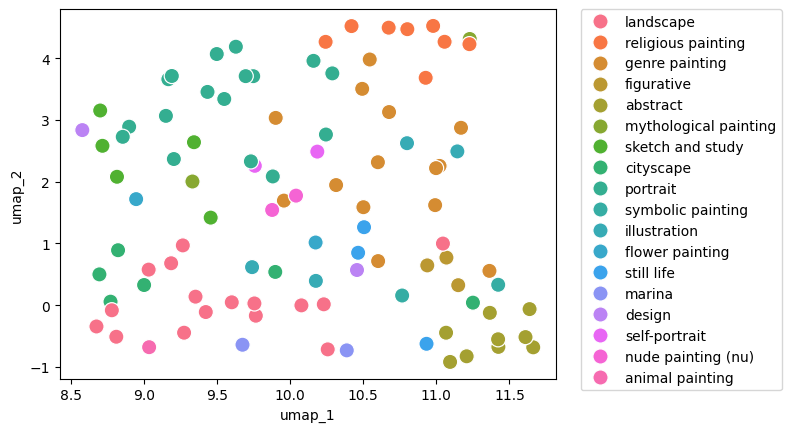

In [13]:

labels = LabelEncoder().fit_transform(sampled_test_set["genre"].values)
reduced = umap.UMAP()

embedding = reduced.fit_transform(StandardScaler().fit_transform(out_features))

umap_result_df = pd.DataFrame({'umap_1': embedding[:,0], 'umap_2': embedding[:,1], 'label': sampled_test_set["genre"].values})

fig, ax = plt.subplots(1)
sns.scatterplot(x='umap_1', y='umap_2', hue='label', data=umap_result_df, ax=ax,s=120)
lim = (embedding.min()-5, embedding.max()+5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

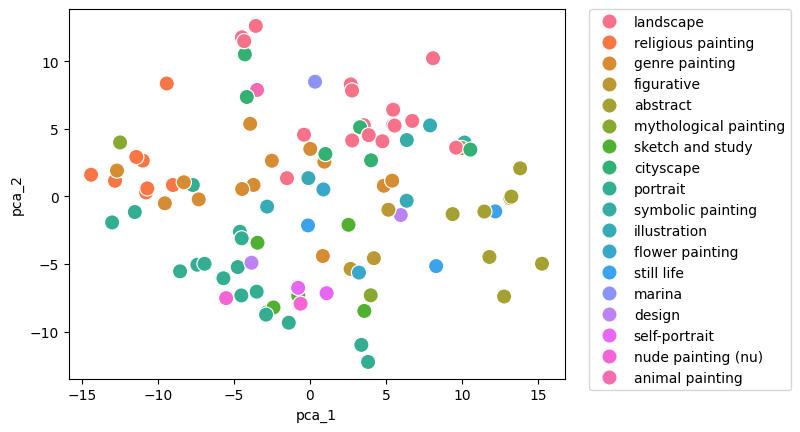

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components)
pca_trans = pca.fit_transform(StandardScaler().fit_transform(out_features))
pca_result_df = pd.DataFrame({'pca_1': pca_trans[:,0], 'pca_2': pca_trans[:,1], 'label': sampled_test_set["genre"].values})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=120)
lim = (pca_trans.min()-5, pca_trans.max()+5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)